# Пункт 6. #

**Импорт библиотек**

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.svm import SVC  
import matplotlib.pyplot as plt

**Формирование признаков и целевой переменной**

In [2]:
df = pd.read_excel('data/course_data_clean_log.xlsx')
cc50_median = df['CC50, mM'].median()
df['CC50_above_median'] = (df['CC50, mM'] > cc50_median).astype(int)

drop_cols = ['IC50, mM', 'CC50, mM', 'SI', 'log_IC50', 'log_CC50', 'log_SI', 'CC50_above_median']
X = df.drop(columns=drop_cols, errors='ignore')
y = df['CC50_above_median']

**Разделение данных на обучающую и тестовую выборки**

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

**Подготовка к обучению логистической регрессии SVC и Random Forest**

In [4]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Обучение, визуализация метрик и поиск лучшей модели**

In [5]:
models = {
    'LogisticRegression': (
        LogisticRegression(max_iter=2000, random_state=42),
        {'C': [0.01, 0.1, 1, 10, 100]}
    ),
    'RandomForestClassifier': (
        RandomForestClassifier(random_state=42),
        {'n_estimators': [100, 200], 'max_depth': [5, 10, None], 'min_samples_leaf': [1, 3, 5]}
    ),
    'SVC': (
        SVC(probability=True, random_state=42),
        {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'], 'kernel': ['rbf', 'linear']}
    )
}

results = {}

In [6]:
for name, (model, params) in models.items():
    print(f'\n=== {name} ===')
    grid = GridSearchCV(model, params, cv=5, scoring='roc_auc', n_jobs=-1)
    grid.fit(X_train_scaled, y_train)
    print("Лучшие параметры:", grid.best_params_)
    y_pred = grid.predict(X_test_scaled)
    y_proba = grid.predict_proba(X_test_scaled)[:, 1] if hasattr(grid, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba if y_proba is not None else y_pred)
    print(f'Accuracy: {acc:.3f}, F1: {f1:.3f}, ROC AUC: {roc_auc:.3f}')

    results[name] = {
        'model': grid.best_estimator_,
        'acc': acc,
        'f1': f1,
        'roc_auc': roc_auc,
        'y_pred': y_pred,
        'y_proba': y_proba
    }


=== LogisticRegression ===
Лучшие параметры: {'C': 0.1}
Accuracy: 0.726, F1: 0.749, ROC AUC: 0.805

=== RandomForestClassifier ===
Лучшие параметры: {'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 200}
Accuracy: 0.687, F1: 0.707, ROC AUC: 0.832

=== SVC ===
Лучшие параметры: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Accuracy: 0.716, F1: 0.730, ROC AUC: 0.802


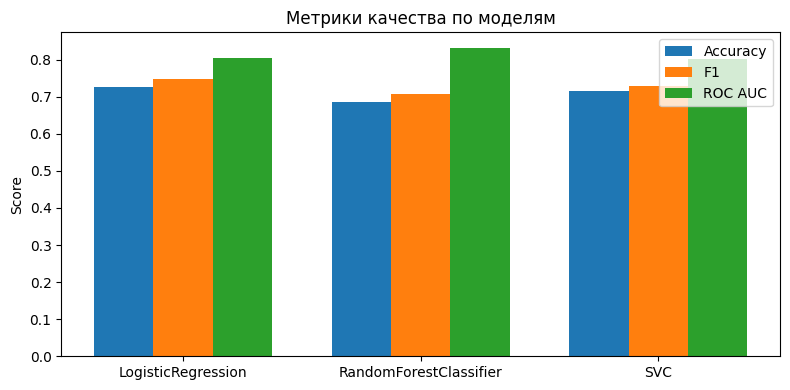

In [7]:
fig, ax = plt.subplots(figsize=(8, 4))
names = list(results.keys())
roc_aucs = [results[n]['roc_auc'] for n in names]
f1s = [results[n]['f1'] for n in names]
accs = [results[n]['acc'] for n in names]

x = np.arange(len(names))
width = 0.25

ax.bar(x - width, accs, width, label='Accuracy')
ax.bar(x, f1s, width, label='F1')
ax.bar(x + width, roc_aucs, width, label='ROC AUC')
ax.set_xticks(x)
ax.set_xticklabels(names)
ax.set_ylabel('Score')
ax.set_title('Метрики качества по моделям')
ax.legend()
plt.tight_layout()
plt.show()

Лучшая модель: RandomForestClassifier

Classification report:
              precision    recall  f1-score   support

           0      0.721     0.614     0.663       101
           1      0.661     0.760     0.707       100

    accuracy                          0.687       201
   macro avg      0.691     0.687     0.685       201
weighted avg      0.691     0.687     0.685       201

Confusion matrix:


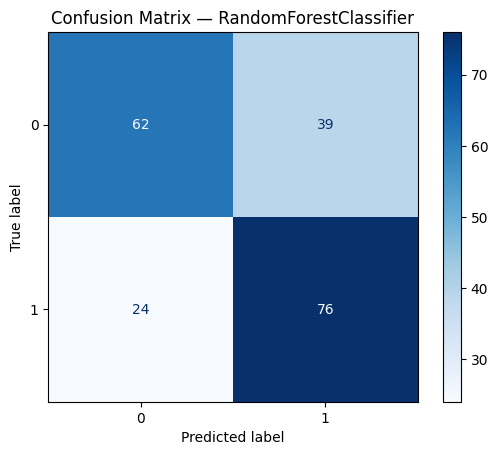

In [8]:
best_model_key = max(results, key=lambda x: results[x]['roc_auc'])
best_model = results[best_model_key]['model']
y_pred_best = results[best_model_key]['y_pred']

print(f'Лучшая модель: {best_model_key}')
print('\nClassification report:')
print(classification_report(y_test, y_pred_best, digits=3))

print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix — {best_model_key}')
plt.show()